In [13]:
import pandas as pd
import numpy as np
import pingouin as pg
from tensorflow.keras.models import Model,model_from_json,load_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, fbeta_score

In [14]:
note_predictions=pd.read_csv("data.csv")
note_predictions=note_predictions[note_predictions['second_prescription_onward']==1]
print(note_predictions.shape)

(15593, 62)


In [15]:
data_test=note_predictions[note_predictions['train_val_test']==3]
print(data_test.shape)
data_dep =note_predictions[(note_predictions['dep_model_addnotesmodelpatient']==1)&(note_predictions['annotated_new']==1)]
print(data_dep.shape)

(90, 62)
(366, 62)


In [17]:
test_auc = roc_auc_score(data_test['y'],data_test['y_pre_new'])
print(test_auc)
dep_auc = roc_auc_score(data_dep['y'],data_dep['y_pre_new'])
print(dep_auc)

0.9333836098541981
0.9123186836977699


In [18]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred_val= data_dep['y_pre_class_new']
y_val= data_dep['y']

y_pred_test= data_test['y_pre_class_new']
y_test= data_test['y']

p_lg_val = data_dep['y_pre_new']
p_lg_test = data_test['y_pre_new']

cm_val = confusion_matrix(y_pred_val, y_val)
cm_test = confusion_matrix(y_pred_test, y_test)
#print(cm_train)

lg_auc_val = np.round(roc_auc_score(y_val, p_lg_val), decimals=4)
lg_auc_test = np.round(roc_auc_score(y_test, p_lg_test), decimals=4)

acc_val = np.round(accuracy_score(y_pred_val, y_val), decimals=4)
acc_test = np.round(accuracy_score(y_pred_test, y_test), decimals=4)

rec_val = np.round(cm_val[1,1]/(cm_val[1,1]+cm_val[0,1]), decimals=4)
rec_test = np.round(cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]), decimals=4)

specificity_val = np.round(cm_val[0,0]/(cm_val[0,0]+cm_val[1,0]), decimals=4)
specificity_test = np.round(cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]), decimals=4)


print('........................MODEL PERFORMANCE......................')
print('              Validation    Test')
print('AUC          :', lg_auc_val, '      ', lg_auc_test)
print('Accuracy     :', acc_val, '     ', acc_test) 
print('Recall       :', rec_val, '     ', rec_test)
print('Specificity  :', specificity_val, '      ', specificity_test)


........................MODEL PERFORMANCE......................
              Validation    Test
AUC          : 0.9123        0.9334
Accuracy     : 0.8907       0.8667
Recall       : 0.8725       0.8718
Specificity  : 0.9032        0.8627


In [19]:
data_test_dep = note_predictions[((note_predictions['dep_model_addnotesmodelpatient']==1)&(note_predictions['annotated_new']==1))|(note_predictions['train_val_test']==3)]
print(data_test_dep.shape)

(456, 62)


In [20]:
data_test_dep_female = data_test_dep[data_test_dep['gender']=='FEMALE']
print(data_test_dep_female.shape)
data_test_dep_male = data_test_dep[data_test_dep['gender']=='MALE']
print(data_test_dep_male.shape)
data_test_dep_private = data_test_dep[data_test_dep['ins']==1]
print(data_test_dep_private.shape)
data_test_dep_public = data_test_dep[data_test_dep['ins']==0]
print(data_test_dep_public.shape)
data_test_dep_young = data_test_dep[data_test_dep['age_at_first_prescription'] <= 7]
print(data_test_dep_young.shape)
data_test_dep_old = data_test_dep[data_test_dep['age_at_first_prescription'] > 7]
print(data_test_dep_old.shape)


(143, 62)
(313, 62)
(322, 62)
(134, 62)
(138, 62)
(318, 62)


In [21]:
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions.to_numpy()[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

#df= pd.read_csv('stjude_selected_features_last.csv')

alpha = .95
#df= pd.read_csv('echo_mice.csv')
#df = df[df['train_test'] == 3]
#df.reset_index(inplace=True) 


y_pred = data_test_dep_female['y_pre_new']
y_true = data_test_dep_female['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

70.0
AUC: 0.9265166340508806
AUC COV: 0.0005178645223186457
95% AUC CI: [0.88191445 0.97111882]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [23]:
y_pred = data_test_dep['y_pre_new']
y_true = data_test_dep['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

188.0
AUC: 0.916749364877739
AUC COV: 0.00020661852132764844
95% AUC CI: [0.88857639 0.94492234]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [47]:
y_pred = data_test_dep_male['y_pre_new']
y_true = data_test_dep_male['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

118.0
AUC: 0.9102564102564101
AUC COV: 0.0003490374336161006
95% AUC CI: [0.8736393  0.94687352]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [49]:
y_pred = data_test_dep_private['y_pre_new']
y_true = data_test_dep_private['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

122.0
AUC: 0.9105737704918032
AUC COV: 0.0003293544225711658
95% AUC CI: [0.8750041  0.94614344]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [50]:
y_pred = data_test_dep_public['y_pre_new']
y_true = data_test_dep_public['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

66.0
AUC: 0.92825311942959
AUC COV: 0.0005801835801090477
95% AUC CI: [0.88104347 0.97546277]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [14]:
y_pred = data_test_dep_young['y_pre_new']
y_true = data_test_dep_young['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

56.0
AUC: 0.9250871080139375
AUC COV: 0.0006556943873698351
95% AUC CI: [0.87489923 0.97527498]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_52779/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_52779/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [15]:
y_pred = data_test_dep_old['y_pre_new']
y_true = data_test_dep_old['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

131.0
AUC: 0.9130345563490109
AUC COV: 0.00030655117169511284
95% AUC CI: [0.87871833 0.94735079]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_52779/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_52779/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [25]:
y_pred = data_test['y_pre_new']
y_true = data_test['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

39.0
AUC: 0.9333836098541981
AUC COV: 0.0008113731926591198
95% AUC CI: [0.87755479 0.98921243]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

In [27]:
y_pred = data_dep['y_pre_new']
y_true = data_dep['y']
print(y_true.sum())
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

149.0
AUC: 0.9123186836977701
AUC COV: 0.0002734971179779763
95% AUC CI: [0.87990529 0.94473207]


/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_20355/3943944266.py:143: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var

/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/4286526236.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot([auc_val, auc_val], [i, i], 'ro', color=color, markersize=8)
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_95131/4286526236.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot([lower_ci_model1[i], upper_ci_model1[i]], [i, i], 'r-', color=color)


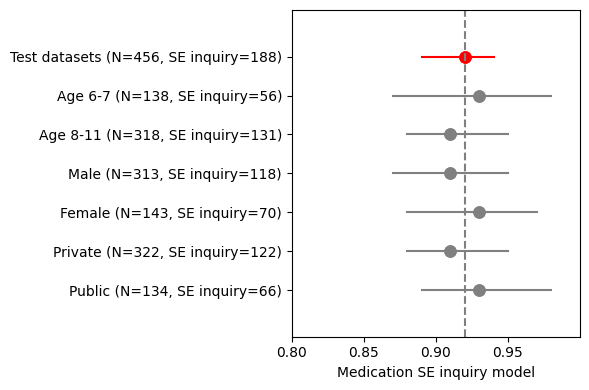

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import re

subgroups = ["Public (N=134, SE inquiry=66)", "Private (N=322, SE inquiry=122)", "Female (N=143, SE inquiry=70)", "Male (N=313, SE inquiry=118)", "Age 8-11 (N=318, SE inquiry=131)", "Age 6-7 (N=138, SE inquiry=56)", "Test datasets (N=456, SE inquiry=188)"]
             
auc_model1 = [0.93, 0.91, 0.93, 0.91, 0.91, 0.93, 0.92]
lower_ci_model1 = [0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.89]
upper_ci_model1 = [0.98, 0.95, 0.97, 0.95, 0.95, 0.98, 0.94]

fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1, width_ratios=[1])

line_position1 = auc_model1[6]

# Panel 1 - Model 1
ax1 = plt.subplot(gs[0])
for i, sub in enumerate(subgroups):
    color = 'red' if i == 6 else 'gray'
    auc_val = auc_model1[i]
    ax1.plot([auc_val, auc_val], [i, i], 'ro', color=color, markersize=8)
    ax1.plot([lower_ci_model1[i], upper_ci_model1[i]], [i, i], 'r-', color=color)
    ax1.set_xlim(0.9, 1)

ax1.set_xlabel('Medication SE inquiry model')
ax1.set_yticks(range(len(subgroups)))
ax1.set_yticklabels(subgroups,size=10)
ax1.set_xticks(np.arange(0.8, 1, 0.05))
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.margins(y=0.2)

ax1.axvline(x=line_position1, color='gray', linestyle='--')

ax1.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('forest_plot_inquiry.png', dpi=300)

plt.tight_layout()
plt.show()


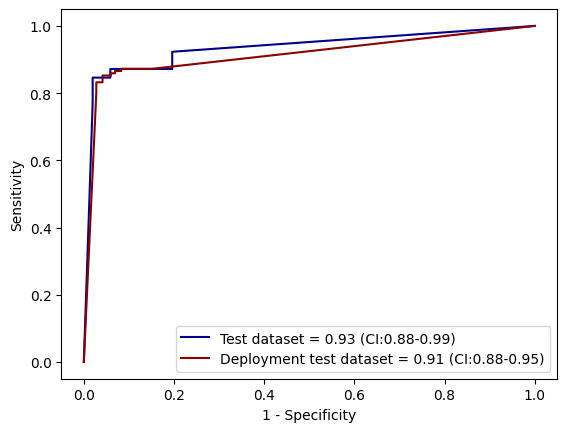

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_pred_proba1 = data_test['y_pre_new']
y_test1 = data_test['y']

y_pred_proba2 = data_dep['y_pre_new']
y_test2 = data_dep['y']

fpr1, tpr1, _ = metrics.roc_curve(y_test1,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test1, y_pred_proba1)

fpr2, tpr2, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test2, y_pred_proba2)

plt.plot(fpr1,tpr1,color='darkblue',label='Test dataset = %0.2f (CI:%0.2f-%0.2f)' % (0.93,0.88,0.99))
plt.plot(fpr2,tpr2,color='darkred',label='Deployment test dataset = %0.2f (CI:%0.2f-%0.2f)' % (0.91,0.88,0.95))

plt.legend(loc=4)
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
#plt.show()
#plt.savefig('Figure 2.tiff', dpi=350)
plt.savefig('Figure 1.png', format='png', dpi=350)

In [32]:
adhd_clinical = pd.read_csv('data_clinical.csv')

In [33]:
adhd_clinical=adhd_clinical.dropna(subset=['pre'])
adhd_clinical=adhd_clinical[adhd_clinical['Include']==1]
adhd_clinical.shape

(1247, 34)

In [54]:
df_temp = adhd_clinical
print(df_temp.shape)
comparison_col = 'pre_prescrip_new'

def p_val_fisher(col):
    tab = pd.crosstab(df_temp[col], df_temp[comparison_col])
    return fisher_exact(tab)[1]

def asd(col):
    asd=pg.compute_effsize(df_temp[df_temp[comparison_col]==0][col],
                                    df_temp[df_temp[comparison_col]==1][col],
                                    eftype='cohen')
    return np.round(asd,2)

def np_overall(col):
    nn = df_temp[df_temp[col] == 1].shape[0]
    pp = np.round(100 * df_temp[col].mean(),1)
    return '%s (%s)' %(nn, pp)

def np_no(col):
    nn = df_temp[(df_temp[col] == 1) & (df_temp[comparison_col] == 0)].shape[0]
    pp = np.round(100 * df_temp[df_temp[comparison_col] == 0][col].mean(),1)
    return '%s (%s)' %(nn, pp)

def np_yes(col):
    nn = df_temp[(df_temp[col] == 1) & (df_temp[comparison_col] == 1)].shape[0]
    pp = np.round(100 * df_temp[df_temp[comparison_col] == 1][col].mean(),1)
    return '%s (%s)' %(nn, pp)

bernoulli = ['sex','x0_Other', 'x0_Asian',
       'x0_Black.or.African.American',
        'x0_White','x0_Hispanic','x0_No_matching_concept', 'ins','public', 'age7_diag', 'age7_prescrip']
                                  
xx=[]
for col in bernoulli:
    try:
        xx.append([col, 
                   np_overall(col),
                   np_no(col),
                   np_yes(col),
                   p_val_fisher(col),
                   asd(col)
                  ])
    except:
        xx.append([col, 
               np_overall(col),
               np_no(col),
               np_yes(col),
               '-',
               asd(col)
              ])
       

vals = pd.DataFrame(xx, columns=['feature',
                                 'overall', 
                                 'no SE',
                                 'SE',
                                 'p', 'asd'])
vals.set_index('feature')
vals

(1247, 34)


,feature,overall,no SE,SE,p,asd
0,sex,922 (74.1),131 (73.6),791 (74.1),-,-0.01
1,x0_Other,9 (0.7),0 (0.0),9 (0.8),-,-0.10
2,x0_Asian,74 (5.9),9 (5.0),65 (6.1),-,-0.05
3,x0_Black.or.African.American,60 (4.8),3 (1.7),57 (5.3),-,-0.17
4,x0_White,549 (44.0),71 (39.4),478 (44.8),-,-0.11
5,x0_Hispanic,190 (15.2),30 (16.7),160 (15.0),-,0.05
6,x0_No_matching_concept,365 (29.3),67 (37.2),298 (27.9),-,0.20
7,ins,929 (74.5),150 (83.3),779 (73.0),-,0.24
8,public,318 (25.5),30 (16.7),288 (27.0),-,-0.24
9,age7_diag,342 (27.4),37 (20.6),305 (28.6),-,-0.18


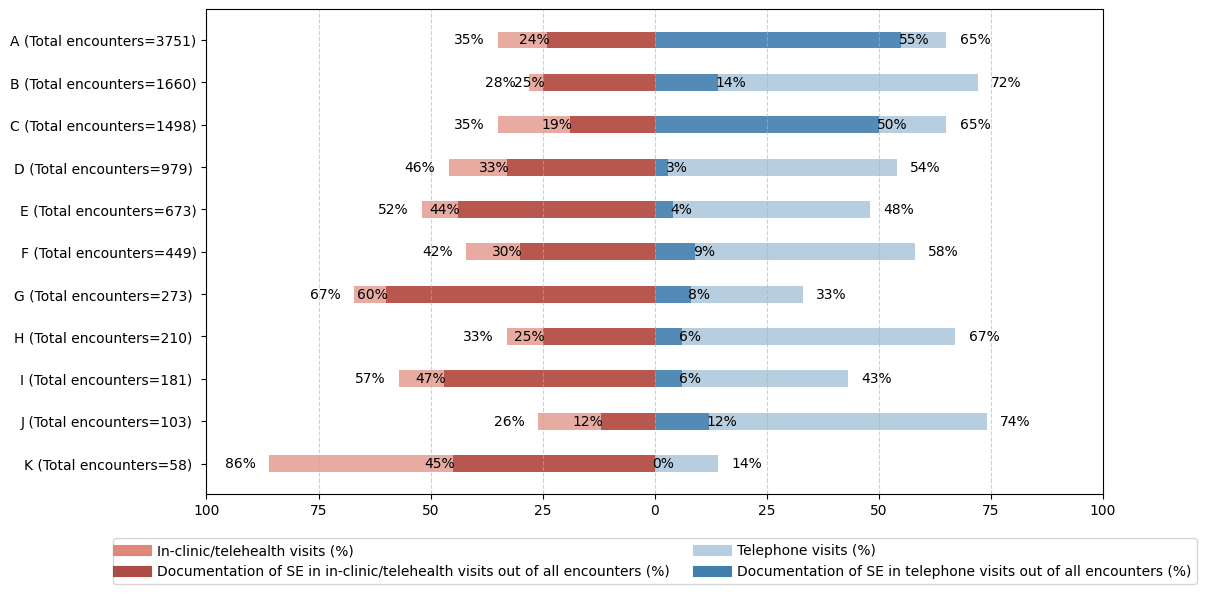

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data = [
    ["K (Total encounters=58) ", 86, 14, 0, 45],
    ["J (Total encounters=103) ", 26, 74, 12, 12],
    ["I (Total encounters=181) ", 57, 43, 6, 47],
    ["H (Total encounters=210) ", 33, 67, 6, 25],
    ["G (Total encounters=273) ",67, 33, 8, 60],
    ["F (Total encounters=449)", 42, 58, 9, 30],
    ["E (Total encounters=673)", 52, 48, 4, 44],
    ["D (Total encounters=979) ",46, 54, 3, 33],
    ["C (Total encounters=1498)", 35, 65, 50, 19],
    ["B (Total encounters=1660)", 28, 72, 14, 25],
    ["A (Total encounters=3751)",35, 65, 55, 24]
]

all_visits = [entry[0] for entry in data]
clinic_visits = [entry[1] for entry in data]
telehealth_visits = [entry[2] for entry in data]
clinic_visits_pre = [entry[3] for entry in data]
telehealth_visits_pre = [entry[4] for entry in data]

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.4

# Position for each bar
index = np.arange(len(all_visits))

# Plot in-clinic visits as negative values
plt.barh(index, [-x for x in clinic_visits], bar_width, color="#df8879", alpha=0.7)
# Plot telehealth visits as positive values
plt.barh(index, telehealth_visits, bar_width, color="#115f9a", alpha=0.3)

# Plot percentage of SE inquery for in clinic visits starting from the origin
plt.barh(index, clinic_visits_pre, bar_width, color="#115f9a", alpha=0.6, left=[0] * len(all_visits))
# Plot percentage of SE inquery for telehealth visits starting from the origin
plt.barh(index, [-x for x in telehealth_visits_pre], bar_width, color="#991f17", alpha=0.6, left=[0] * len(all_visits))

# Set x-axis limits to -60 and 60
plt.xlim(-100, 100)

# Add labels and title
plt.yticks(index, all_visits, rotation=0)

# Annotate percentage SE inquery for in clinic visits at the end of bars
for i, value in enumerate(clinic_visits_pre):
    plt.text(abs(value)-0.5 , i, f'{value}%', ha='left', va='center', fontsize=10, color='black')

# Annotate percentage SE inquery for telehealth visits the end of bars
for i, value in enumerate(telehealth_visits_pre):
    plt.text(-value+0.5 , i, f'{value}%', ha='right', va='center', fontsize=10, color='black')

# Annotate in clinic visits at the end of bars
for i, value in enumerate(clinic_visits):
    plt.text(-value-3 , i, f'{value}%', ha='right', va='center', fontsize=10, color='black')

# Annotate telehealth visits at the end of bars
for i, value in enumerate(telehealth_visits):
    plt.text(value+3 , i, f'{value}%', ha='left', va='center', fontsize=10, color='black')

# Set x-axis ticks to positive values on the negative side
ax.set_xticks([-x for x in ax.get_xticks()])
ax.set_xticklabels([str(int(np.abs(x))) for x in ax.get_xticks()])

# Create custom legend labels
legend_labels = [
    plt.Line2D([0], [0], color="#df8879", lw=8, label='In-clinic/telehealth visits (%)'),
    plt.Line2D([0], [0], color="#991f17", lw=8, alpha=0.8, label='Documentation of SE in in-clinic/telehealth visits out of all encounters (%)'),
    plt.Line2D([0], [0], color="#115f9a", lw=8, alpha=0.3,label='Telephone visits (%)'),
    plt.Line2D([0], [0], color="#115f9a", lw=8, alpha=0.8, label='Documentation of SE in telephone visits out of all encounters (%)'),
    
]

# Add the legend at the bottom and flatten it
ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('SE_inquiry_plot.png', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_7369/3978533178.py:5: DtypeWarning: Columns (41,42,43,44,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/iluo/Library/CloudStorage/Box-Box/DBP Health Services Research/NLP_ADHD/Medication_management/clinical_questions/adhd_visits_predictions_04_04_medtype3month.csv')
/var/folders/d_/ch0mqbr502501l5ct2lfd9_40000gn/T/ipykernel_7369/3978533178.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20c')


pre_new           0   1
med_type_3month        
1.0              61  39
2.0              48  52
3.0              47  53
pre_new             0     1
med_type_3month            
1.0              5440  3458
2.0               197   212
3.0               247   281
SignificanceResult(statistic=1.6929477148552756, pvalue=2.633275445440499e-07)
SignificanceResult(statistic=1.0571575891834084, pvalue=0.6925347958633601)
SignificanceResult(statistic=1.7897125248499637, pvalue=1.1364002726493613e-10)
0 Stimulants
61 5440 61
39 3458 100
1 Non stimulants
48 197 48
52 212 100
2 Both
47 247 47
53 281 100


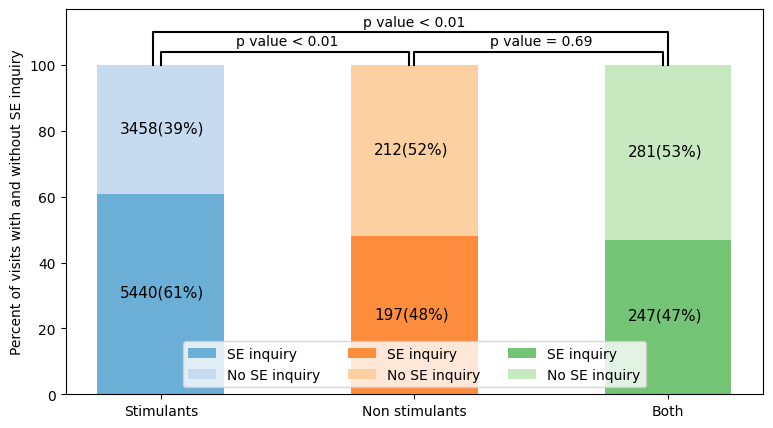

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('adhd_visits_predictions.csv')

# Create a colormap
colormap = plt.cm.get_cmap('tab20c')

cross_tab_prop1 = (pd.crosstab(index=df['med_type_3month'],
                              columns=df['pre_new'],
                              normalize="index") * 100).round(0).astype(int)
cross_tab1 = pd.crosstab(index=df['med_type_3month'],
                         columns=df['pre_new'])

cross_tab_prop = pd.concat([cross_tab_prop1])
cross_tab_prop.iloc[:, 0], cross_tab_prop.iloc[:, 1] = cross_tab_prop.iloc[:, 1].copy(), cross_tab_prop.iloc[:, 0].copy()
print(cross_tab_prop)
cross_tab_prop.index = ['Stimulants', 'Non stimulants', 'Both']

cross_tab = pd.concat([cross_tab1])
cross_tab.iloc[:, 0], cross_tab.iloc[:, 1] = cross_tab.iloc[:, 1].copy(), cross_tab.iloc[:, 0].copy()
cross_tab.index = ['Stimulants', 'Non stimulants', 'Both']

fig, ax = plt.subplots(figsize=(9, 5))

# Create custom colors for each bar within each pair
stimulants = [colormap(1), colormap(3)]  # Change the indices to select specific colors
non_stimulants = [colormap(5), colormap(7)]  # Change the indices to select specific colors
both = [colormap(9), colormap(11)]

bar_width = 0.5
bar_positions = np.arange(len(cross_tab_prop.index))

# Plot the first pair of bars (intervention) with custom colors
ax.bar(bar_positions[0:1], cross_tab_prop.iloc[0:1, 0], width=bar_width, label='SE inquiry', color=stimulants[0])
ax.bar(bar_positions[0:1], cross_tab_prop.iloc[0:1, 1], width=bar_width, label='No SE inquiry', color=stimulants[1],bottom=cross_tab_prop.iloc[0:1, 0])

# Plot the second pair of bars (post-intervention) with custom colors stacked on top of the first pair
ax.bar(bar_positions[1:2], cross_tab_prop.iloc[1:2, 0], width=bar_width, label='SE inquiry', color=non_stimulants[0])
ax.bar(bar_positions[1:2], cross_tab_prop.iloc[1:2, 1], width=bar_width, label='No SE inquiry', color=non_stimulants[1], bottom=cross_tab_prop.iloc[1:2, 0])

# Plot the second pair of bars (post-intervention) with custom colors stacked on top of the first pair
ax.bar(bar_positions[2:3], cross_tab_prop.iloc[2:3, 0], width=bar_width, label='SE inquiry', color=both[0])
ax.bar(bar_positions[2:3], cross_tab_prop.iloc[2:3, 1], width=bar_width, label='No SE inquiry', color=both[1], bottom=cross_tab_prop.iloc[2:3, 0])

from scipy.stats import fisher_exact
print(cross_tab1)
print(fisher_exact(cross_tab1.iloc[0:2,:], alternative='two-sided'))
print(fisher_exact(cross_tab1.iloc[1:3,:], alternative='two-sided'))
print(fisher_exact(cross_tab1.iloc[[0,2],:], alternative='two-sided'))

plt.xticks(bar_positions, cross_tab_prop.index, rotation=0, ha='center')
plt.legend(loc="lower center", ncol=3)
plt.xlabel("")
plt.ylabel("Percent of visits with and without SE inquiry")
plt.ylim(bottom=0, top=117)

for n, x in enumerate([*cross_tab.index.values]):
    print(n,x)
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x], cross_tab.loc[x], cross_tab_prop.loc[x].cumsum()):
        print(proportion, count, y_loc)
        plt.text(x=n-0.16, y=(y_loc - proportion-1 ) + (proportion / 2), s=f'{count}'f'({int(proportion)}%)',
                 color="black", fontsize=11)


plt.plot([0, 0, 0.98, 0.98], [100, 104, 104, 100], lw=1.5, c='black')
plt.text(0.5, 105, "p value < 0.01", ha='center', va='bottom')
plt.plot([1, 1, 1.98, 1.98], [100, 104, 104, 100], lw=1.5, c='black')
plt.text(1.5, 105, "p value = 0.69", ha='center', va='bottom')
plt.plot([-0.03, -0.03, 2, 2], [100, 110, 110, 100], lw=1.5, c='black')
plt.text(1, 111, "p value < 0.01", ha='center', va='bottom')
plt.savefig('stacked_bar_chart.png', bbox_inches='tight', dpi=300)
plt.show()
